In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

import torch.distributed as dist

sys.path.insert(0, "../../src")

import numpy as np
import torch
import zarr as z

from juart.conopt.functional.fourier import (
    nonuniform_fourier_transform_adjoint,
)
from juart.dl.loss.loss import JointLoss
from juart.dl.model.dc import DataConsistency
from juart.dl.model.resnet import ResNet
from juart.dl.model.unrollnet import (
    LookaheadModel,
    UnrolledNet,
)
from juart.dl.operation.modules import training
from juart.dl.utils.dist import GradientAccumulator
from juart.vis.interactive import InteractiveMultiPlotter3D

In [2]:
cgiter = 10
features = 32
num_resblocks = 10
num_unrollblocks = 10

nX, nY, nZ, nTI, nTE = 128, 128, 128, 1, 1
shape = (nX, nY, nZ, nTI, nTE)
dtype = torch.complex64

store = z.open("/home/jovyan/datasets/num_phantom_128_R1")

C = torch.from_numpy(np.array(store["C"]))
k = torch.from_numpy(np.array(store["k"]))[..., None, None]
d = torch.from_numpy(np.array(store["d"]))[..., None, None]

In [3]:
generator = torch.Generator()
generator.manual_seed(0)

kspace_mask_source = torch.randint(0, 2, (1, d.shape[1], 1, 1), generator=generator)
kspace_mask_target = 1 - kspace_mask_source
d_masked = d * kspace_mask_source

AHd = nonuniform_fourier_transform_adjoint(k, d_masked, (nX, nY, nZ))
AHd = torch.sum(torch.conj(C[..., None, None]) * AHd, dim=0)

data = [
    {
        "images_regridded": AHd,
        "kspace_trajectory": k,
        "sensitivity_maps": C,
        "kspace_mask_source": kspace_mask_source,
        "kspace_mask_target": kspace_mask_target,
        "kspace_data": d,
    }
]

In [4]:
def train_loop(device):
    model = UnrolledNet(
        shape,
        features=features,
        CG_Iter=cgiter,
        num_unroll_blocks=num_unrollblocks,
        num_res_blocks=num_resblocks,
        activation="ReLU",
        disable_progress_bar=False,
        timing_level=0,
        validation_level=0,
        kernel_size=(3, 3, 3),
        axes=(1, 2, 3),
        ResNetCheckpoints=True,
        device=device,
        dtype=dtype,
    )

    loss_fn = JointLoss(
        shape,
        3,
        weights_kspace_loss=(0.5, 0.5),
        weights_ispace_loss=(0.0, 0.0),
        weights_wavelet_loss=(0.0, 0.0),
        weights_hankel_loss=(0.0, 0.0),
        weights_casorati_loss=(0.0, 0.0),
        normalized_loss=True,
        timing_level=0,
        validation_level=0,
        device=device,
        dtype=dtype,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.01, betas=[0.9, 0.999], eps=1.0e-8, weight_decay=0.0
    )

    accumulator = GradientAccumulator(
        model, accumulation_steps=1, max_norm=1.0, normalized_gradient=False
    )

    averaged_model = LookaheadModel(model, alpha=0.5, k=5)

    image = training(
        [0],
        data,
        model,
        loss_fn,
        optimizer,
        accumulator,
        10,
        device=device,
    )

    return image

In [5]:
def DCRES_Block(device):
    resnet = ResNet(
        contrasts=1,
        features=features,
        dim=3,
        num_of_resblocks=num_resblocks,
        device=device,
        kernel_size=(3, 3, 3),
        ResNetCheckpoints=True,
    )

    dc_block = DataConsistency(
        shape, axes=(1, 2, 3), device=device, verbose=True, niter=cgiter
    )

    dc_block.init(
        data[0]["images_regridded"],
        data[0]["kspace_trajectory"],
        sensitivity_maps=data[0]["sensitivity_maps"],
        kspace_mask=data[0]["kspace_mask_source"],
    )

    image = data[0]["images_regridded"]
    print(image.shape)
    with torch.no_grad():
        for _ in range(0, num_unrollblocks, 1):
            image = resnet(image)
            image = dc_block(image)

    return image

In [6]:
dist.init_process_group(
    backend="gloo", init_method="tcp://127.0.0.1:13579", world_size=1, rank=0
)

In [7]:
image = train_loop("cuda:3")
# dcres_image = DCRES_Block("cuda:3")

Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 4.139 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 93.296
Averaged gradient norm: 1.000
Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 1.299 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 13.072
Averaged gradient norm: 1.000
Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 1.042 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 1.402
Averaged gradient norm: 1.000
Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 0.998 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 0.515
Averaged gradient norm: 0.515
Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 0.987 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 0.242
Averaged gradient norm: 0.242
Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 0.971 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 0.143
Averaged gradient norm: 0.143
Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 0.975 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 0.072
Averaged gradient norm: 0.072
Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 0.980 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 0.046
Averaged gradient norm: 0.046
Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 0.988 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 0.067
Averaged gradient norm: 0.067
Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 0.982 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 0.064
Averaged gradient norm: 0.064


interactive(children=(IntSlider(value=64, description='Dimension 3:', max=128, min=1), Output()), _dom_classes…

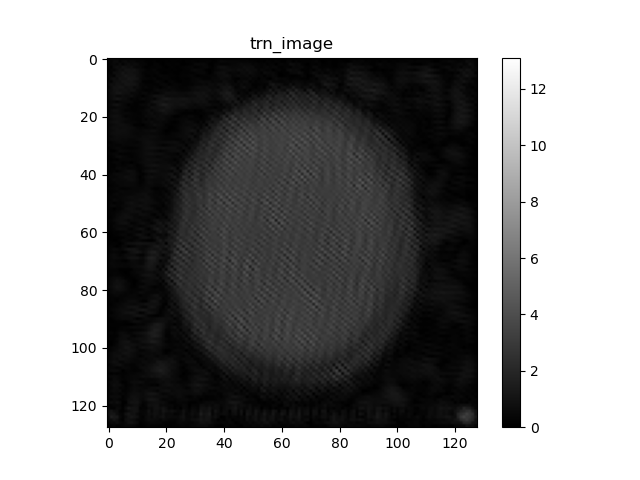

In [8]:
InteractiveMultiPlotter3D(
    [image[..., 0, 0].cpu().abs().detach().numpy()],
    title=["trn_image"],
    vmin=0,
    vmax=image[..., 0, 0].cpu().abs().max(),
).interactive